In [1]:
import pandas as pd
import numpy as np

In [2]:
df_softreboot = pd.read_csv("log_files/softreboot_stopserver.csv")
df_softreboot.mean()

action_time                  6.000000
service_restart_time         0.000000
get_ip_time                  0.000003
total_time                  25.581866
qos_difference          -45443.327281
qos_average             235093.446125
qos_error_percentage         0.373711
normal_qos              228421.963163
dtype: float64

In [3]:
df_hardreboot = pd.read_csv("log_files/hardreboot_stopserver.csv")
df_hardreboot.mean()

action_time                 17.000000
service_restart_time        31.000000
get_ip_time                 33.141676
total_time                  84.728058
qos_difference           16934.010517
qos_average             237047.206678
qos_error_percentage         0.001219
normal_qos              226538.779028
dtype: float64

In [4]:
df_scaleup = pd.read_csv("log_files/scaleup_stopserver.csv")
df_scaleup.mean()

total_time                 154.247029
create_new_snapshot         24.000000
create_new_vm                8.000000
assign_floating_ip          54.000000
ansible_run                 34.431835
qos_difference           51609.558954
qos_average             236801.445267
qos_error_percentage         0.001889
normal_qos              251949.852912
dtype: float64

In [5]:
df_migrate = pd.read_csv("log_files/migrate_stopserver.csv")
df_migrate.mean()

action                      84.853236
total_time                  23.000000
create_new_vm                6.000000
assign_floating_ip           6.000000
ansible_run                  1.227992
qos_difference            4122.361648
qos_average             237110.188650
qos_error_percentage         0.001177
normal_qos              228519.870643
dtype: float64

In [6]:
df_resize = pd.read_csv("log_files/serverresize_stopserver.csv")
df_resize.mean()

action_time                 18.000000
action_confirm_time          6.000000
total_time                  47.179675
ansbie_run                   0.000000
qos_difference          -53051.536285
qos_average             236976.184171
qos_error_percentage         1.945856
normal_qos              230238.380912
dtype: float64

In [7]:
df_restartservice = pd.read_csv("log_files/restartservice_stopserver.csv")
df_restartservice.mean()

total_time                   2.664301
qos_difference          -62294.450846
qos_average             255066.324790
qos_error_percentage         1.619087
normal_qos                   0.000000
dtype: float64

#### Adjusting parameters for TOPSIS

- Sucess probability
- MTTR
- number of steps
- Impact percentage
- error percentage


In [8]:
dataframe = [df_softreboot,df_hardreboot,df_resize,df_migrate,df_scaleup,df_restartservice]
df_index = ["soft_reboot","hard_reboot","resize","migrate","scaleUp","restart_service"]

### factors

sucess_probability = [0,100,0,100,100,0]
MTTR = [df_softreboot['total_time'].mean(),df_hardreboot['total_time'].mean(),df_resize['total_time'].mean() \
        ,df_migrate['total_time'].mean(),df_scaleup['total_time'].mean(),df_restartservice['total_time'].mean()]
no_of_steps=[3,3,4,6,5,1]
error_percentage = [df_softreboot['qos_error_percentage'].mean(),df_hardreboot['qos_error_percentage'].mean(),df_resize['qos_error_percentage'].mean() \
        ,df_migrate['qos_error_percentage'].mean(),df_scaleup['qos_error_percentage'].mean(),df_restartservice['qos_error_percentage'].mean()]

### impact calculations
impact_diff = [df_softreboot['qos_difference'].mean(),df_hardreboot['qos_difference'].mean(),df_resize['qos_difference'].mean() \
        ,df_migrate['qos_difference'].mean(),df_scaleup['qos_difference'].mean(),df_restartservice['qos_difference'].mean()]
max(impact_diff)
min(impact_diff)

## conversion since qos2 - qos1, negative results are scewing results
for i in range(0,len(impact_diff)):
    impact_diff[i] = impact_diff[i] + (-1*min(impact_diff))
    



### Normalization

In [9]:
# OldRange = (OldMax - OldMin)  
# NewRange = (NewMax - NewMin)  
# NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin

#MTTR
OldRange = (max(MTTR) - min(MTTR))  
NewRange = (100 - 0)
n_mttr = []
for val in MTTR:
    n_val = (((val - min(MTTR)) * NewRange) / OldRange) + 0
    n_mttr.append(n_val)
    
#no of steps
scaled_noofsteps = []
for lol in no_of_steps:
    NewValue = (((lol - min(no_of_steps)) * 100) / 5) + 0 # formula in last block
    scaled_noofsteps.append(NewValue)

#impact difference
OldRange = (max(impact_diff) - min(impact_diff))  
NewRange = (100 - 0)
n_impactdiff = []
for val in impact_diff:
    n_val = (((val - min(impact_diff)) * NewRange) / OldRange) + 0
    n_impactdiff.append(n_val)

# error_percentage
OldRange = (max(error_percentage) - min(error_percentage))  
NewRange = (100 - 0)
n_error_percentage = []
for val in error_percentage:
    n_val = (((val - min(error_percentage)) * NewRange) / OldRange) + 0
    n_error_percentage.append(n_val)



In [10]:
df = pd.DataFrame()
df[0] = df_index
df[1] = MTTR
df[2] = no_of_steps
df[3] = impact_diff
df[4] = error_percentage
df[5] = sucess_probability

df.columns = ['Alternatives', 'MTTR','Number of Steps','Impact','Error Percentage','Sucess Probability']
#model = df
#df.set_index('Alternatives',inplace=True)
df = df.drop('Alternatives',axis=1)
df

,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability
0,25.581866,3,16851.123565,0.373711,0
1,84.728058,3,79228.461363,0.001219,100
2,47.179675,4,9242.914561,1.945856,0
3,23.000000,6,66416.812495,0.001177,100
4,154.247029,5,113904.009800,0.001889,100
5,2.664301,1,0.000000,1.619087,0


### Entropy Method with TOPSIS

In [11]:
import math
from decimal import *
### step 1 : normalize
### step 2:
# sum of columns e=divided by all
df.loc["Total"] = df.sum()
df['MTTR'] = df['MTTR']/df['MTTR']["Total"]
df['Number of Steps'] = df['Number of Steps']/df['Number of Steps']["Total"]
df['Impact'] = df['Impact']/df['Impact']["Total"]
df['Error Percentage'] = df['Error Percentage']/df['Error Percentage']["Total"]
df['Sucess Probability'] = df['Sucess Probability']/df['Sucess Probability']["Total"]
df = df[:-1]
df

,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability
0,0.075820,0.136364,0.058994,0.094780,0.000000
1,0.251120,0.136364,0.277369,0.000309,0.333333
2,0.139833,0.181818,0.032358,0.493504,0.000000
3,0.068168,0.272727,0.232517,0.000299,0.333333
4,0.457162,0.227273,0.398763,0.000479,0.333333
5,0.007897,0.045455,0.000000,0.410630,0.000000


In [12]:
### compute entropy
#df = df[:-1]
### 1/log(m) m is number of alternatives 
h = 1/math.log(6)

for index, row in df.iterrows():
    if row['MTTR'] > 0:
        row['MTTR'] = row['MTTR'] * math.log(row['MTTR'])
    if row['Number of Steps']!=0:    
        row['Number of Steps'] = row['Number of Steps'] * math.log(row['Number of Steps'])
    if row['Impact']!=0:
        row['Impact'] = row['Impact'] * math.log(row['Impact'])
    if row['Error Percentage']!=0:
        row['Error Percentage'] = row['Error Percentage'] * math.log(row['Error Percentage'])
    if row['Sucess Probability']!=0:
        row['Sucess Probability'] = row['Sucess Probability'] * math.log(row['Sucess Probability'])
        
df

,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability
0,-0.195570,-0.271695,-0.166971,-0.223320,0.000000
1,-0.347004,-0.271695,-0.355700,-0.002498,-0.366204
2,-0.275094,-0.309954,-0.111017,-0.348525,0.000000
3,-0.183085,-0.354350,-0.339194,-0.002423,-0.366204
4,-0.357829,-0.336728,-0.366618,-0.003661,-0.366204
5,-0.038230,-0.140502,0.000000,-0.365486,0.000000


In [13]:
df.loc['Total'] = df.sum()
#df = df[:-1]
df


,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability
0,-0.195570,-0.271695,-0.166971,-0.223320,0.000000
1,-0.347004,-0.271695,-0.355700,-0.002498,-0.366204
2,-0.275094,-0.309954,-0.111017,-0.348525,0.000000
3,-0.183085,-0.354350,-0.339194,-0.002423,-0.366204
4,-0.357829,-0.336728,-0.366618,-0.003661,-0.366204
5,-0.038230,-0.140502,0.000000,-0.365486,0.000000
Total,-1.396811,-1.684924,-1.339500,-0.945913,-1.098612


In [14]:
df2 = df.copy()
df2.loc['e'] = df2.loc['Total'] * (-(h))
df2


,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability
0,-0.195570,-0.271695,-0.166971,-0.223320,0.000000
1,-0.347004,-0.271695,-0.355700,-0.002498,-0.366204
2,-0.275094,-0.309954,-0.111017,-0.348525,0.000000
3,-0.183085,-0.354350,-0.339194,-0.002423,-0.366204
4,-0.357829,-0.336728,-0.366618,-0.003661,-0.366204
5,-0.038230,-0.140502,0.000000,-0.365486,0.000000
Total,-1.396811,-1.684924,-1.339500,-0.945913,-1.098612
e,0.779575,0.940374,0.747589,0.527924,0.613147


In [15]:
df3 = df2.copy()
df3.loc['d'] = 1 - df2.loc['e']
df3

,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability
0,-0.195570,-0.271695,-0.166971,-0.223320,0.000000
1,-0.347004,-0.271695,-0.355700,-0.002498,-0.366204
2,-0.275094,-0.309954,-0.111017,-0.348525,0.000000
3,-0.183085,-0.354350,-0.339194,-0.002423,-0.366204
4,-0.357829,-0.336728,-0.366618,-0.003661,-0.366204
5,-0.038230,-0.140502,0.000000,-0.365486,0.000000
Total,-1.396811,-1.684924,-1.339500,-0.945913,-1.098612
e,0.779575,0.940374,0.747589,0.527924,0.613147
d,0.220425,0.059626,0.252411,0.472076,0.386853


In [16]:
dsum = sum(df3.loc['d'])
df4 = df3.copy()
df4.loc['w'] = df3.loc['d'] / dsum
df4


,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability
0,-0.195570,-0.271695,-0.166971,-0.223320,0.000000
1,-0.347004,-0.271695,-0.355700,-0.002498,-0.366204
2,-0.275094,-0.309954,-0.111017,-0.348525,0.000000
3,-0.183085,-0.354350,-0.339194,-0.002423,-0.366204
4,-0.357829,-0.336728,-0.366618,-0.003661,-0.366204
5,-0.038230,-0.140502,0.000000,-0.365486,0.000000
Total,-1.396811,-1.684924,-1.339500,-0.945913,-1.098612
e,0.779575,0.940374,0.747589,0.527924,0.613147
d,0.220425,0.059626,0.252411,0.472076,0.386853
w,0.158421,0.042853,0.181409,0.339284,0.278033


#### Applying TOPSIS with weights calculated by Entropy

In [17]:
from skcriteria import Data, MIN, MAX
#df = df.drop('Alternatives',axis=1)
df5 = df4[:-4]
mtx = [df5.loc[0],df5.loc[1],df5.loc[2],df5.loc[3],df5.loc[4],df5.loc[5]]
mtx
criteria = [min,min,max,min,max]
criteria
data = Data(mtx, [min,min,max,min,max])
data
data = Data(mtx, criteria,
            weights=df4.loc['w'],
            anames=["soft reboot", "hard reboot","resize","migrate","scaleUp","restart_service"],
            cnames=["MTTR", "Number of Steps", "Impact","Error Percentage","Success Probability"])
data # first result here

ALT./CRIT.,MTTR (min) W.0.15842071611451003,Number of Steps (min) W.0.0428533918308015,Impact (max) W.0.18140909915991071,Error Percentage (min) W.0.33928352970355186,Success Probability (max) W.0.27803326319122607
soft reboot,-0.19557,-0.271695,-0.166971,-0.22332,0
hard reboot,-0.347004,-0.271695,-0.3557,-0.00249763,-0.366204
resize,-0.275094,-0.309954,-0.111017,-0.348525,0
migrate,-0.183085,-0.35435,-0.339194,-0.00242322,-0.366204
scaleUp,-0.357829,-0.336728,-0.366618,-0.00366128,-0.366204
restart_service,-0.0382298,-0.140502,0,-0.365486,0


In [18]:
dm = closeness.TOPSIS()
dm
dec = dm.decide(data)
dec

NameError: name 'closeness' is not defined

In [ ]:
dm = closeness.TOPSIS(mnorm="sum")
dm.decide(data)

In [ ]:
print(dec.e_)
print("Ideal:", dec.e_.ideal)
print("Anti-Ideal:", dec.e_.anti_ideal)
print("Closeness:", dec.e_.closeness)

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title("Sum Norm")
data.plot.violin(mnorm="sum", ax=ax1);

ax2.set_title("Vector Norm")
data.plot.violin(mnorm="vector", ax=ax2);
f.set_figwidth(15)

### Using scikit-criteria

In [21]:
from skcriteria import Data, MIN, MAX
#df = df.drop('Alternatives',axis=1)
mtx = [df.loc[0],df.loc[1],df.loc[2],df.loc[3],df.loc[4],df.loc[5]]
mtx
criteria = [min,min,max,min,max]
criteria
data = Data(mtx, [min,min,max,min,max])
data
data = Data(mtx, criteria,
            weights=[0.1, 0.1, 0.1,0.1,0.5],
            anames=["soft reboot", "hard reboot","resize","migrate","scaleUp","restart_service"],
            cnames=["MTTR", "Number of Steps", "Impact","Error Percentage","Success Probability"])
data # first result here





ALT./CRIT.,MTTR (min) W.0.1,Number of Steps (min) W.0.1,Impact (max) W.0.1,Error Percentage (min) W.0.1,Success Probability (max) W.0.5
soft reboot,-0.19557,-0.271695,-0.166971,-0.22332,0
hard reboot,-0.347004,-0.271695,-0.3557,-0.00249763,-0.366204
resize,-0.275094,-0.309954,-0.111017,-0.348525,0
migrate,-0.183085,-0.35435,-0.339194,-0.00242322,-0.366204
scaleUp,-0.357829,-0.336728,-0.366618,-0.00366128,-0.366204
restart_service,-0.0382298,-0.140502,0,-0.365486,0


In [20]:
from skcriteria.madm import closeness, simple

In [114]:
dm = simple.WeightedSum()
dm

<WeightedSum (mnorm=sum, wnorm=sum)>

In [115]:
# Now lets decide the ranking
dec = dm.decide(data)
dec

ALT./CRIT.,MTTR (min) W.0.1,Number of Steps (min) W.0.1,Impact (max) W.0.1,Error Percentage (min) W.0.1,Success Probability (max) W.0.5,Rank
soft reboot,25.5819,3,16851.1,0.373711,0,5
hard reboot,84.7281,3,79228.5,0.0012185,100,2
resize,47.1797,4,9242.91,1.94586,0,6
migrate,23,6,66416.8,0.00117718,100,1
scaleUp,154.247,5,113904,0.00188861,100,3
restart_service,2.6643,1,0,1.61909,0,4


In [116]:
dm = closeness.TOPSIS()
dm
dec = dm.decide(data)
dec

ALT./CRIT.,MTTR (min) W.0.1,Number of Steps (min) W.0.1,Impact (max) W.0.1,Error Percentage (min) W.0.1,Success Probability (max) W.0.5,Rank
soft reboot,25.5819,3,16851.1,0.373711,0,4
hard reboot,84.7281,3,79228.5,0.0012185,100,1
resize,47.1797,4,9242.91,1.94586,0,6
migrate,23,6,66416.8,0.00117718,100,2
scaleUp,154.247,5,113904,0.00188861,100,3
restart_service,2.6643,1,0,1.61909,0,5


In [117]:
dm = closeness.TOPSIS(mnorm="sum")
dm.decide(data)

ALT./CRIT.,MTTR (min) W.0.1,Number of Steps (min) W.0.1,Impact (max) W.0.1,Error Percentage (min) W.0.1,Success Probability (max) W.0.5,Rank
soft reboot,25.5819,3,16851.1,0.373711,0,4
hard reboot,84.7281,3,79228.5,0.0012185,100,2
resize,47.1797,4,9242.91,1.94586,0,6
migrate,23,6,66416.8,0.00117718,100,1
scaleUp,154.247,5,113904,0.00188861,100,3
restart_service,2.6643,1,0,1.61909,0,5


In [118]:
print(dec.e_)
print("Ideal:", dec.e_.ideal)
print("Anti-Ideal:", dec.e_.anti_ideal)
print("Closeness:", dec.e_.closeness)

Extra(ideal, anti_ideal, closeness)
Ideal: [1.59639702e-03 1.13402303e-02 8.16399697e-02 5.11166144e-05
 3.20750150e-01]
Anti-Ideal: [0.09242179 0.06804138 0.         0.08449511 0.        ]
Closeness: [0.24868212 0.85118055 0.16627517 0.83655618 0.77097522 0.24197464]


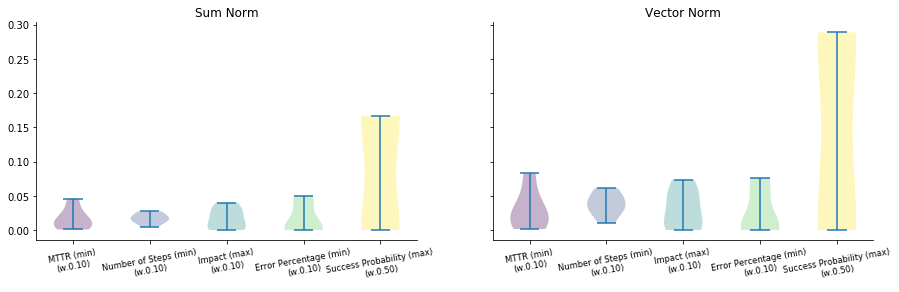

In [119]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title("Sum Norm")
data.plot.violin(mnorm="sum", ax=ax1);

ax2.set_title("Vector Norm")
data.plot.violin(mnorm="vector", ax=ax2);
f.set_figwidth(15)

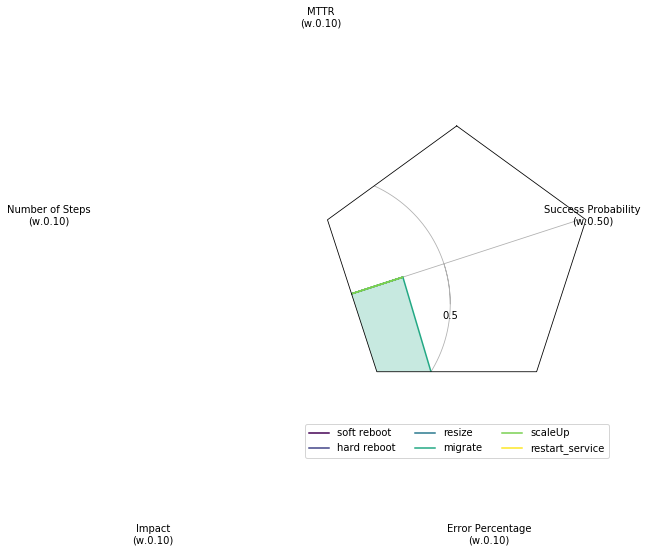

In [127]:
data.plot()

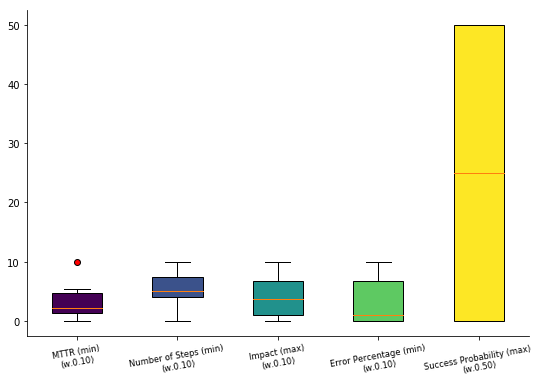

In [128]:

data.plot("box");

### TOPSIS

In [68]:
import math
# step 1 : already in df
# step 2:  normalize
# rij = xij / math.sqrt(sum(m)*(x^2kj))
root_sum = []
#df = df.reset_index()
df2 = pd.DataFrame()
df2[0] = df_index
df2[1] = MTTR
df2[2] = no_of_steps
df2[3] = impact_diff
df2[4] = error_percentage
df2[5] = sucess_probability
df2.columns = ['Alternatives', 'MTTR','Number of Steps','Impact','Error Percentage','Sucess Probability']
#for i in range(0,len(df2)):    
#    root_sum.append(math.sqrt((df2.loc[i]['MTTR'])**2 + (df2.loc[i]['Number of Steps'])**2 + (df2.loc[0]['Impact'])**2 + (df2.loc[0]['Error Percentage'])**2 + (df2.loc[0]['Sucess Probability'])**2))

df2 = df2.drop('Alternatives',axis=1)
df2.loc["Total"] = df2.sum()
#df2['root_sum'] = root_sum
df2.loc["TotalRoot"] = (df2.loc["Total"])**(1/2)

df3 = df2.copy()
df3['MTTR'] = df3['MTTR']/df2['MTTR']["TotalRoot"]
df3['Number of Steps'] = df3['Number of Steps']/df2['Number of Steps']["TotalRoot"]
df3['Impact'] = df3['Impact']/df2['Impact']["TotalRoot"]
df3['Error Percentage'] = df3['Error Percentage']/df2['Error Percentage']["TotalRoot"]
df3['Sucess Probability'] = df3['Sucess Probability']/df2['Sucess Probability']["TotalRoot"]

#df2['Number of Steps'] = df2['Number of Steps']/df2['root_sum']
#df2['Impact'] = df2['Impact']/df2['root_sum']
#df2['Error Percentage'] = df2['Error Percentage']/df2['root_sum']
#df2['Sucess Probability'] = df2['Sucess Probability']/df2['root_sum']

df2



,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability
0,25.581866,3.000000,16851.123565,0.373711,0.000000
1,84.728058,3.000000,79228.461363,0.001219,100.000000
2,47.179675,4.000000,9242.914561,1.945856,0.000000
3,23.000000,6.000000,66416.812495,0.001177,100.000000
4,154.247029,5.000000,113904.009800,0.001889,100.000000
5,2.664301,1.000000,0.000000,1.619087,0.000000
Total,337.400929,22.000000,285643.321784,3.942937,300.000000
TotalRoot,18.368477,4.690416,534.456099,1.985683,17.320508


In [13]:

# step 3: apply weights
MTTR_weight = 0.1
steps_weight = 0.05
impact_weight = 0.1
error_percentage = 0.5
sucess_probability = 0.7

df2['MTTR'] = df2['MTTR'] * MTTR_weight
df2['Number of Steps'] = df2['Number of Steps'] * steps_weight 
df2['Impact'] = df2['Impact'] * impact_weight
df2['Error Percentage'] = df2['Error Percentage'] * error_percentage 
df2['Sucess Probability'] = df2['Sucess Probability'] * sucess_probability

df2


,Alternatives,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability,root_sum
0,soft_reboot,0.000152,0.000009,0.100000,1.108858e-05,0.000000,16851.143254
1,hard_reboot,0.000503,0.000009,0.470161,3.615445e-08,0.004154,16851.336843
2,resize,0.000280,0.000012,0.054850,5.773644e-05,0.000000,16851.190090
3,migrate,0.000136,0.000018,0.394138,3.492865e-08,0.004154,16851.140333
4,scaleUp,0.000915,0.000015,0.675915,5.603562e-08,0.004154,16851.830247
5,restart_service,0.000016,0.000003,0.000000,4.804092e-05,0.000000,16851.123809


In [18]:
# step 4: Determine best and worst solution
#df2 = df2.drop('root_sum',axis=1)
#df2 = df2.drop('Alternatives',axis=1)
#df2.loc[:,'Total'] = df2.sum(axis=1)

df2['max_value'] = df2.max(axis=1)
df2['min_value'] = df2.min(axis=1)

df2


,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability,max_value,min_value
0,0.000152,0.000009,0.100000,1.108858e-05,0.000000,0.100000,0.000000e+00
1,0.000503,0.000009,0.470161,3.615445e-08,0.004154,0.470161,3.615445e-08
2,0.000280,0.000012,0.054850,5.773644e-05,0.000000,0.054850,0.000000e+00
3,0.000136,0.000018,0.394138,3.492865e-08,0.004154,0.394138,3.492865e-08
4,0.000915,0.000015,0.675915,5.603562e-08,0.004154,0.675915,5.603562e-08
5,0.000016,0.000003,0.000000,4.804092e-05,0.000000,0.000048,0.000000e+00


In [28]:
# step 5: determine separation from ideal solution

ideal = df2.copy()
ideal['MTTR'] = (ideal['MTTR'] - ideal['max_value'])**2
ideal['Number of Steps'] = (ideal['Number of Steps'] - ideal['max_value'])**2
ideal['Impact'] = (ideal['Impact'] - ideal['max_value'])**2
ideal['Error Percentage'] = (ideal['Error Percentage'] - ideal['max_value'])**2
ideal['Sucess Probability'] = (ideal['Sucess Probability'] - ideal['max_value'])**2
ideal



,MTTR,Number of Steps,Impact,Error Percentage,Sucess Probability,max_value,min_value
0,9.969638e-03,9.998196e-03,0.000000e+00,0.009998,9.999977e-03,0.100000,0.000000e+00
1,2.205791e-01,2.210433e-01,0.000000e+00,0.221052,2.171628e-01,0.470161,3.615445e-08
2,2.977911e-03,3.007245e-03,0.000000e+00,0.003002,3.008546e-03,0.054850,0.000000e+00
3,1.552375e-01,1.553310e-01,0.000000e+00,0.155345,1.520878e-01,0.394138,3.492865e-08
4,4.556243e-01,4.568407e-01,0.000000e+00,0.456861,4.512627e-01,0.675915,5.603562e-08
5,1.038779e-09,2.031644e-09,2.307930e-09,0.000000,2.307930e-09,0.000048,0.000000e+00


In [ ]:

worst = df2.copy()
worst['MTTR'] = (worst['MTTR'] - worst['min_value'])**2
worst['Number of Steps'] = (worst['Number of Steps'] - worst['min_value'])**2
worst['Impact'] = (worst['Impact'] - worst['min_value'])**2
worst['Error Percentage'] = (worst['Error Percentage'] - worst['min_value'])**2
worst['Sucess Probability'] = (worst['Sucess Probability'] - worst['min_value'])**2
worst

ideal_array = []
ideal_array.append(math.sqrt(sum(ideal['MTTR'])))
ideal_array.append(math.sqrt(sum(ideal['Number of Steps'])))
ideal_array.append(math.sqrt(sum(ideal['Impact'])))
ideal_array.append(math.sqrt(sum(ideal['Error Percentage'])))
ideal_array.append(math.sqrt(sum(ideal['Sucess Probability'])))

worst_array = []
worst_array.append(math.sqrt(sum(worst['MTTR'])))
worst_array.append(math.sqrt(sum(worst['Number of Steps'])))
worst_array.append(math.sqrt(sum(worst['Impact'])))
worst_array.append(math.sqrt(sum(worst['Error Percentage'])))
worst_array.append(math.sqrt(sum(worst['Sucess Probability'])))

print(ideal_array)
print(worst_array)


In [39]:
## Last step: determine relative closeness to ideal solution

addition = [x + y for x, y in zip(ideal_array, worst_array)]
results =  [x / y for x, y in zip(worst_array, addition)]

#results: similarity to the worst condition
#df2 = df2.drop('max_value',axis=1)
#df2 = df2.drop('min_value',axis=1)
#print(addition)
print(df2.columns)
print(results)
df3 = pd.DataFrame(df2.columns)
#df3.columns = df2.columns
#df3[0] = results
df3
df3['results'] = results
df3
##changes to row wise instead of column wise in last two steps

Index(['MTTR', 'Number of Steps', 'Impact', 'Error Percentage',
       'Sucess Probability'],
      dtype='object')
[0.0011960234723673497, 3.153573916903796e-05, 0.9999477801995241, 8.252572978726203e-05, 0.007818973549404189]


,0,results
0,MTTR,0.001196
1,Number of Steps,0.000032
2,Impact,0.999948
3,Error Percentage,0.000083
4,Sucess Probability,0.007819
